# Data Science Essentials: GeoPandas
    Nathaniel Neubert
    Class
    10/6/2020

In [1]:
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from matplotlib import animation
%matplotlib inline

## Problem 1

Read in the file *airports.csv* as a pandas dataframe.
Create three convex hulls around the three sets of airports listed below.
This can be done by passing in lists of the airports' coordinates to a *shapely.geometry.Polygon* object.

1. Maio Airport, Scatsta Airport, Stokmarknes Skagen Airport, Bekily Airport, K. D. Matanzima Airport, RAF Ascension Island
2. Oiapoque Airport, Maio Airport, Zhezkazgan Airport, Walton Airport, RAF Ascension Island, Usiminas Airport, Piloto Osvaldo Marques Dias Airport
3. Zhezkazgan Airport, Khanty Mansiysk Airport, Novy Urengoy Airport, Kalay Airport, Biju Patnaik Airport, Walton Airport
	
Create a new GeoDataFrame with these three Polygons as entries.
Plot this GeoDataFrame on top of an outlined world map.

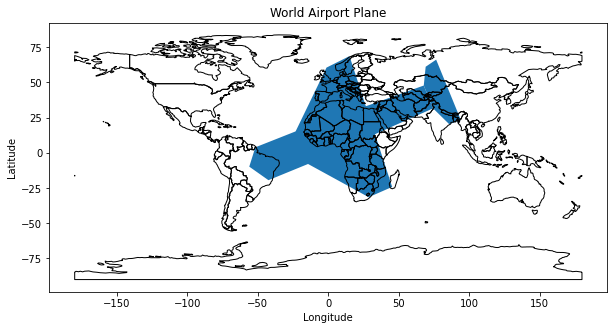

In [2]:
airportsraw = pd.read_csv("airports.csv")
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
airports = airportsraw[['Name','Longitude',"Latitude"]]
airports = airports.set_index('Name')

first_set = ['Maio Airport', 'Scatsta Airport', 'Stokmarknes Skagen Airport',
                 'Bekily Airport','K. D. Matanzima Airport', 'RAF Ascension Island']
second_set = ['Oiapoque Airport','Maio Airport', 'Zhezkazgan Airport',
                'Walton Airport','RAF Ascension Island','Usiminas Airport',
                 'Piloto Osvaldo Marques Dias Airport']
third_set = ['Zhezkazgan Airport','Khanty Mansiysk Airport','Novy Urengoy Airport',
                 'Kalay Airport','Biju Patnaik Airport','Walton Airport']  

firstSet = []
for airport in first_set:
    lat = airports.loc[airport]["Latitude"]
    lon = airports.loc[airport]["Longitude"]
    firstSet.append([lon,lat])
firstPoly = Polygon(firstSet)

secondSet = []
for airport in second_set:
    lat = airports.loc[airport]["Latitude"]
    lon = airports.loc[airport]["Longitude"]
    secondSet.append([lon,lat])
secondPoly = Polygon(secondSet)

thirdSet = []
for airport in third_set:
    lat = airports.loc[airport]["Latitude"]
    lon = airports.loc[airport]["Longitude"]
    thirdSet.append([lon,lat])
thirdPoly = Polygon(thirdSet)

airport_hulls = pd.DataFrame({'geometry': [firstPoly, secondPoly, thirdPoly]})
airportgpd = gpd.GeoDataFrame(airport_hulls, geometry='geometry')


fig,ax = plt.subplots(figsize=(10,7), ncols=1, nrows=1)
base = world.boundary.plot(edgecolor='black', ax=ax, linewidth = 1)
airportgpd.plot(ax=base)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('World Airport Plane')
plt.show()

## Problem 2
Use the command *geopandas.read_file('county_data.gpkg')* to create a GeoDataFrame of information about US counties.
Each county's shape is stored in the *geometry* column.
Use this to **plot the outlines of all US counties two times**, first using the default CRS and then using EPSG:5071.

Next, create a new GeoDataFrame that combines all counties within a single state.
Drop states with the following STATEFP codes: 02, 15, 60, 66, 69, 72, 78.
Plot this GeoDataFrame to see an outline of the 48 contiguous states.
Ensure a CRS of 5071.

In [2]:
def prob2():
    """
    Create data_range for index of paycheck data

    Returns:
        df (DataFrame): DataFrame of paycheck data
    """
    #Load Data
    county_data = gpd.read_file('county_data.gpkg')
    
    #Mercator Projection
    county_shapes = pd.DataFrame({'geometry': county_data['geometry']})
    county_shapes_gpd = gpd.GeoDataFrame(county_shapes, geometry='geometry')
    county_shapes_gpd.plot(edgecolor='black', linewidth = .3, figsize=(14,21))
    plt.title("Mercator Projection")
    
    #5071 Projection
    county_data.to_crs(epsg=5071, inplace=True)
    county_shapes = pd.DataFrame({'geometry': county_data['geometry']})
    county_shapes_gpd = gpd.GeoDataFrame(county_shapes, geometry='geometry')
    county_shapes_gpd.plot(edgecolor='black', linewidth = .3, figsize=(14,21))
    plt.title("5071 Projection")
    
    #5071 Projection States combined
    comp_county = county_data.dissolve(by = "STATEFP")
    comp_county.drop(['02', '15', '60', '66', '69', '72', '78'], inplace=True)
    county_shapes = pd.DataFrame({'geometry': comp_county['geometry']})
    county_shapes_gpd = gpd.GeoDataFrame(county_shapes, geometry='geometry')
    county_shapes_gpd.plot(edgecolor='black', linewidth = .3, figsize=(14,21))
    plt.title("5071 Continental Projection")
    
    
    plt.show()
    
    return comp_county
    

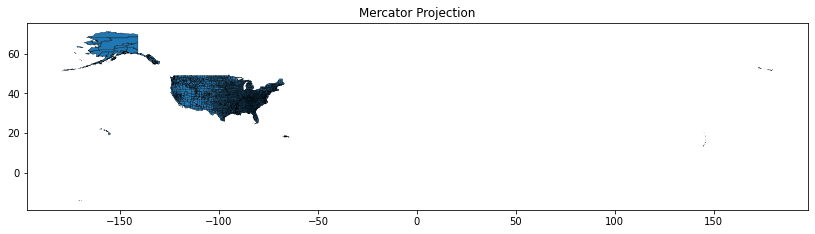

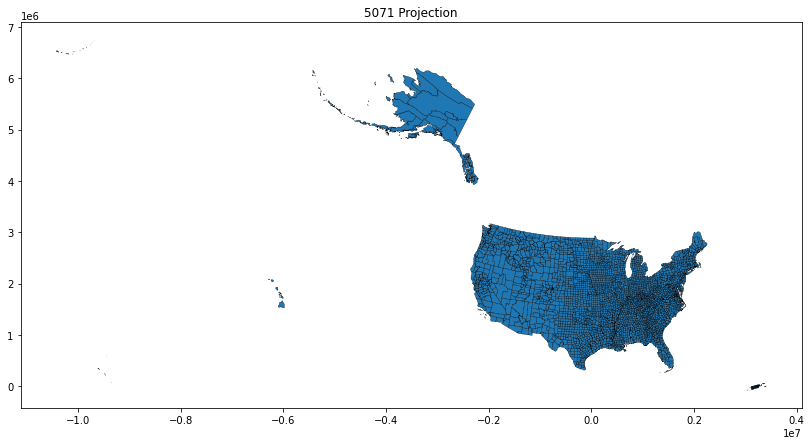

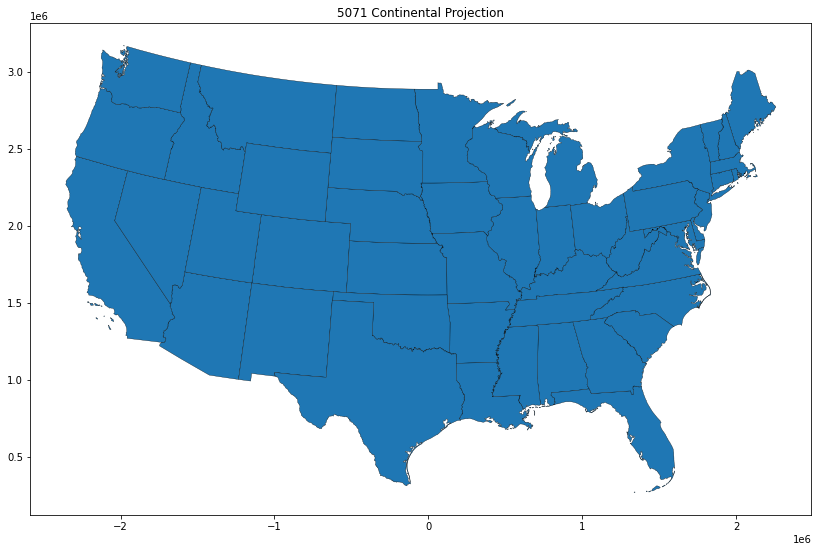

In [3]:
cp = prob2()

## Problem 3

Load in the file *nytimes.csv* as a DataFrame.
This file includes county-level data for the cumulative cases and deaths of Covid-19 in the US, starting with the first case in Snohomish County, Washington, on January 21, 2020.
**First, convert the *date* column into a *DatetimeIndex*.**

Next, use county FIPS codes to **merge your GeoDataFrame from the previous problem with the DataFrame you just created.**
A FIPS code is a 5-digit unique identifier for geographic locations.
For this lab, we will ignore rows in the Covid-19 DataFramw tih unknown FIPS codes.
Also, we will just be examining data from the contiguous US, so **drop all data from Hawaii and Alaska.**

Note that the *fips* column of the Covid-19 DataFrame stores entries as floats, but the county GeoDataFrame stores FIPS codes as strings, with the first two digits in the *STATEFP* column and the last three in the *COUNTYFP* column.

**Plot the cases from March 21, 2020 on top of your state outline map from the previous problem.
Finally, print out the name of the county with the most cases along with its case count.**

In [4]:
def prob3():
    """
    Create period range as index

    Returns:
        df (DataFrame): DataFrame of finance data
    """
    covid = pd.read_csv("nytimes.csv") #df
    covid = covid[covid['state']!='Hawaii']
    covid = covid[covid['state']!='Alaska']
    covid['date'] = pd.to_datetime(covid['date'])
    def fixnyc(x):
        idd = str(x)[:-2]
        if len(idd)==4:
            idd='0'+idd
        return idd
    
    covid['fips'] = covid['fips'].apply(fixnyc)
    
    county_data = gpd.read_file('county_data.gpkg')
    county_data.to_crs(epsg=5071, inplace=True)
    comp_county = county_data.dissolve(by = "STATEFP")
    comp_county.drop(['02', '15', '60', '66', '69', '72', '78'], inplace=True)
    county_data['fips'] = county_data[['STATEFP','COUNTYFP']].apply(lambda x: str(x['STATEFP'])+str(x['COUNTYFP']), axis = 1)
    
    info = gpd.GeoDataFrame(covid.merge(county_data, on='fips', how='inner'), geometry='geometry')
    
    #start = date(2020,3,21)
    fig, ax = plt.subplots(1,figsize=(15,10))
    comp_county.plot(ax=ax)
    info[info['date'] == '2020-03-21'].plot(column='cases', ax=ax, cmap='OrRd', legend=True)
    
    ax.set_title('Covid Cases on March 21, 2020')
    plt.show()

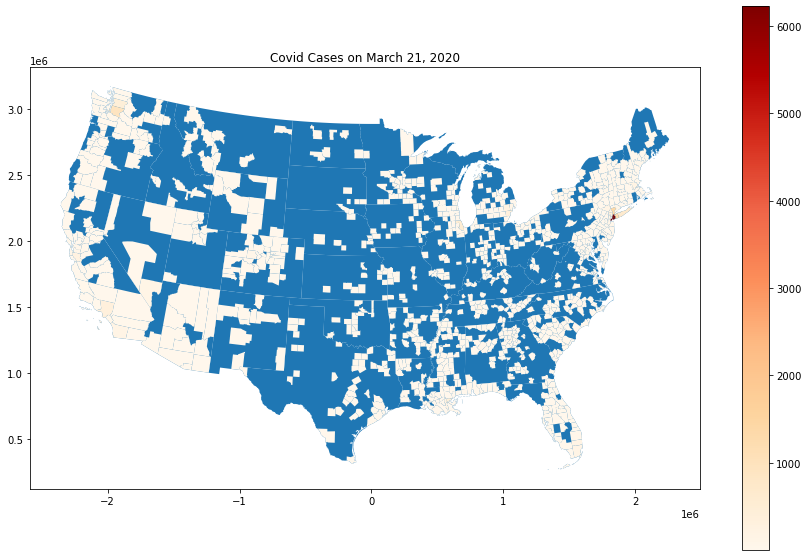

In [5]:
prob3()

## Problem 4

As in Problem 3, plot your state outline map together with a map of Covid-19 cases from March 21, 2020.
This time, use a log scale.
Use EPSG:5071.
Pick a good colormap and be sure to display a colorbar.

In [7]:
def prob4():
    """
    Get average number of users entering a site each
    minute and each hour

    Returns:
        minutes (df): DataFrame containing the number
                      of users entering a website each minutes
        hours (df): DataFrame containing the number of users
                    entering a website each hour
    """
    covid = pd.read_csv("nytimes.csv") #df
    covid = covid[covid['state']!='Hawaii']
    covid = covid[covid['state']!='Alaska']
    covid['date'] = pd.to_datetime(covid['date'])
    def fixnyc(x):
        idd = str(x)[:-2]
        if len(idd)==4:
            idd='0'+idd
        return idd
    
    covid['fips'] = covid['fips'].apply(fixnyc)
    
    county_data = gpd.read_file('county_data.gpkg',)
    #print(county_data.crs)
    county_data.to_crs(epsg = 5071, inplace=True)
    county_data = county_data.rename(columns = {'GEOID':'fips'}).copy()
    
    comp_county = county_data.dissolve(by = "STATEFP")
    comp_county['fips'] = comp_county['fips'].astype('int64')
    comp_county['fips'] = comp_county['fips'].astype('str')
    comp_county.drop(['02', '15', '60', '66', '69', '72', '78'], inplace=True)
    def countyd(x):
        idd = str(x['STATEFP'])+str(x['COUNTYFP'])
        if len(idd)==4:
            idd='0'+idd
        return idd
    county_data['fips'] = county_data[['STATEFP','COUNTYFP']].apply(countyd, axis = 1)
    
    info = gpd.GeoDataFrame(covid.merge(county_data, on='fips', how='inner'), geometry='geometry')
    
    fig, ax = plt.subplots(1,figsize=(15,10))
    data = info[info['date'] == '2020-03-21']
    norm = LogNorm(vmin=min(data['cases']), vmax=max(data['cases']))
    comp_county.plot(ax=ax)
    data.plot(column='cases', ax=ax, cmap='plasma_r', norm=norm,  legend=True)
    
    ax.set_title('Covid Cases on March 21, 2020 on a Log Scale')
    plt.show()
    return info

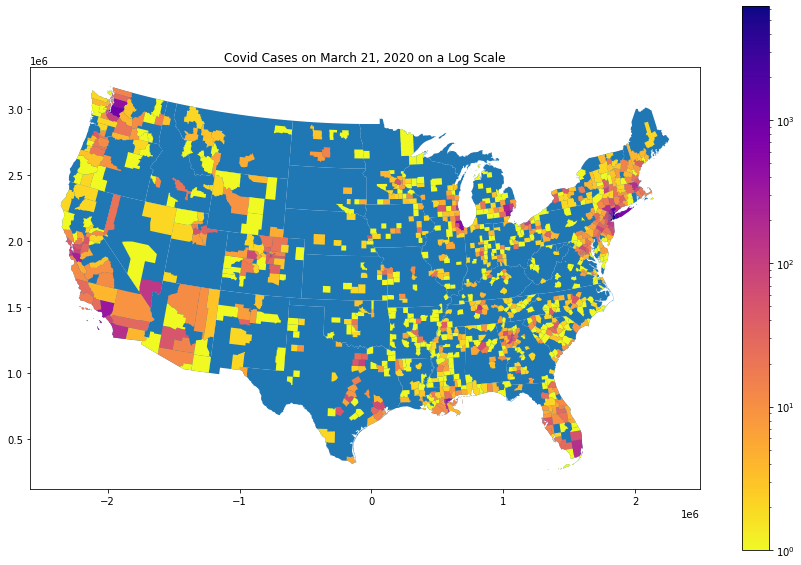

In [8]:
info = prob4()

## Problem 5
In this problem, you will create an animation of the spread of Covid-19 through US counties from January 21, 2020 to June 21, 2020.
Use a log scale and a good colormap, and be sure that you're using the same norm and colorbar for the whole animation.
Use EPSG:5071 for the CRS.

As a reminder, below is a summary of what you will need in order to animate this map.
You may also find it helpful to refer to the animation section included with the Volume 4 lab manual. 

- Set up your figure and norm. Be sure to use the highest case count for your vmax so that the scale remains uniform.
- Write your update function. This should plot the cases from a given day.
- Set up your colorbar. Do this outside the update function to avoid adding a new colorbar each day.
- Create the animation. Check to make sure everything displays properly before you save it.
- Save the animation.
- Display the animation.

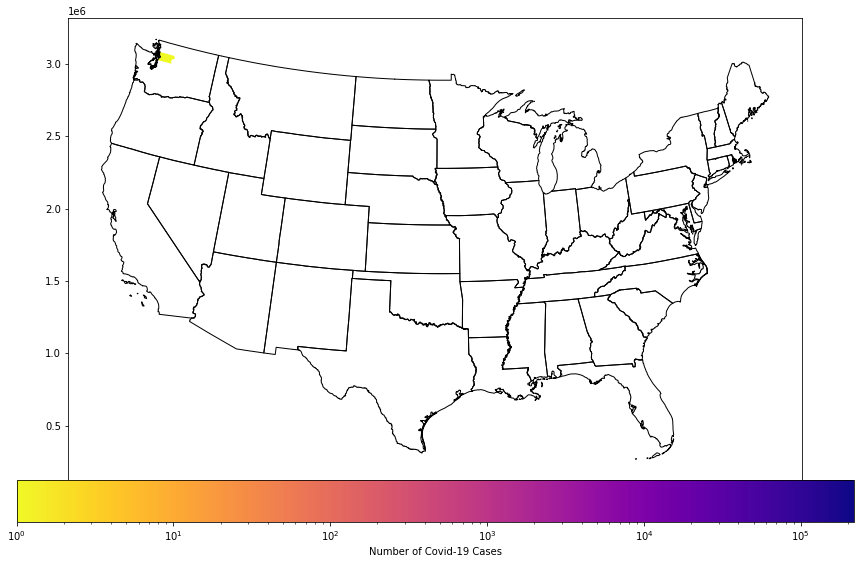

In [70]:
#Set up figure and norm
covid = pd.read_csv("nytimes.csv") #df
def fixnyc(x):
        idd = str(x)[:-2]
        if len(idd)==4:
            idd='0'+idd
        return idd
covid = covid[covid['state']!='Hawaii']
covid = covid[covid['state']!='Alaska']
covid['date'] = pd.to_datetime(covid['date'])
covid['fips'] = covid['fips'].apply(fixnyc)
    
comp_county = county_data.dissolve(by = "STATEFP")
comp_county['fips'] = comp_county['fips'].astype('int64')
comp_county['fips'] = comp_county['fips'].astype('str')
comp_county.drop(['02', '15', '60', '66', '69', '72', '78'], inplace=True)
def countyd(x):
    idd = str(x['STATEFP'])+str(x['COUNTYFP'])
    if len(idd)==4:
        idd='0'+idd
    return idd
county_data['fips'] = county_data[['STATEFP','COUNTYFP']].apply(countyd, axis = 1)
    
info = gpd.GeoDataFrame(covid.merge(county_data, on='fips', how='inner'), geometry='geometry')

dates = sorted(set(info['date']))
fig, ax = plt.subplots(1,figsize=(15,10))
norm = LogNorm(vmin=min(info['cases']), vmax=max(info['cases']))
comp_county.plot(ax=ax)

c = info.loc[info['date'] == dates[0]]
s = c.plot(column = 'cases', cmap='plasma_r', ax=ax, norm=norm)

def update(i):
    date = dates[i]
    ax.clear() #Clear the surface
    cases = info[info['date'] == date]
    base = comp_county.boundary.plot(edgecolor='black', ax=ax, linewidth = 1)
    cases.plot(column='cases', ax=base, cmap='plasma_r', norm=norm)
    #ax.text(0.15,0.15,f'Date: {str(dates[i])[:11]}', transform=ax.transAxes, fontsize=14)
    #Plot the cases from a single day

#Set up the colorbar
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap='plasma_r'),ax=ax,orientation='horizontal', pad = 0, label = "Number of Covid-19 Cases")

#Create the animation
ani = animation.FuncAnimation(fig, update, frames=range(len(dates)), interval=25)
plt.show()

In [71]:
#Save the animation

<video src="covidNathaniel.mp4" controls>